# Fish classification using ResNet101

## setup

In [1]:
# import default libraries
import os
import glob
import shutil
import time
import argparse

In [2]:
import numpy as np
import pandas as pd
from PIL import Image

In [3]:
# import PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchnet.meter import AverageValueMeter, ClassErrorMeter

In [4]:
# global parameters
args = {
    "arch": "resnet101", # resnet50, resnet101, resnet152
    "pretrained": True,
    "datadir": "../data",
    "cuda": True,
    "optim": "adam", # sgd, adam, rmsprop
    "epochs": 100,
    "batch_size": 16,
    "lr": 1e-3,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "seed": 7,
    "workers": 4,
    "nb_augs": 10,
    "cv": 7
}
args = argparse.Namespace(**args)

In [5]:
args.cuda = args.cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [6]:
# data folders
traindir_full = os.path.join(args.datadir, "train")
testdir = os.path.join(args.datadir, "test_stg1")
# intermediate folder
intermediate_path = os.path.join("..", "intermediate")
submission_path = os.path.join(intermediate_path, "submissions")
if not os.path.isdir(submission_path):
    os.makedirs(submission_path)
# get classes
classes = sorted([x.split("/")[-1] for x in glob.glob(traindir_full+"/*")])

In [7]:
# split train/val cross validation
traindir = []
valdir = []

traindir_tmp = os.path.join(intermediate_path, "train_tmp")
g = glob.glob(traindir_full + "/*/*.jpg")
gg = ["/"+x.split("/")[-2]+"/"+x.split("/")[-1] for x in g]
np.random.seed(args.seed)
shuf = np.random.permutation(gg)
ticks = []
for i in range(args.cv):
    ticks.append(i * (len(gg)//args.cv))
ticks.append(len(gg))

for i in range(args.cv):
    traindir.append(os.path.join(intermediate_path, "train{}_{}".format(
        args.cv, str(i))))
    valdir.append(os.path.join(intermediate_path, "val{}_{}".format(
        args.cv, str(i))))
    if not os.path.isdir(traindir[i]):
        shutil.copytree(traindir_full, traindir[i])
    if not os.path.isdir(valdir[i]):
        vals = shuf[ticks[i]:ticks[i+1]]
        for val in vals:
            os.renames(traindir[i] + val, valdir[i] + val)

### utility functions

In [8]:
def save_checkpoint(state, is_best, modelbest_filepath,
                    filename="checkpoint.pth.tar"):
    checkpoint_filepath = os.path.join(intermediate_path, filename)
    torch.save(state, checkpoint_filepath)
    if is_best:
        shutil.copyfile(checkpoint_filepath, modelbest_filepath)

def adjust_learning_rate(args, optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs
    """
    lr = args.lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

### train/validate functions

In [9]:
# train function
def train(args, train_loader, model, criterion, optimizer, epoch):
    # turn on train mode
    model.train()
    losses = AverageValueMeter()
    top1 = ClassErrorMeter(accuracy=True) # accuracy instead of error
    
    for i, (input, target) in enumerate(train_loader):      
        # here we should call cuda() for input;
        # in the ImageNet example, the model is parallel by
        # torch.nn.DataParallel(model).cuda(), so no need to call cuda() there;
        # the option async=True works with pin_memory of DataLoader
        # pin_memory slows down DataLoader but fastens data transfer from
        # CPU to GPU
        if args.cuda:
            input = input.cuda()
            target = target.cuda()
        input_var = Variable(input)
        target_var = Variable(target)

        # compute output and loss
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.add(loss.data[0] * input.size(0), input.size(0))
        top1.add(output.data, target)

In [10]:
# validate function
def validate(args, val_loader, model, criterion, epoch):
    model.train(False) # turn off train mode
    losses = AverageValueMeter()
    top1 = ClassErrorMeter(accuracy=True)
    
    for i, (input, target) in enumerate(val_loader):
        if args.cuda:
            input = input.cuda(async=True)
            target = target.cuda(async=True)
        input_var = Variable(input, volatile=True) # no gradient
        target_var = Variable(target, volatile=True)
        output = model(input_var)
        loss = criterion(output, target_var)
        losses.add(loss.data[0] * input.size(0), input.size(0))
        top1.add(output.data, target)
        
    print("   * EPOCH {:>2} | Accuracy: {:.3f} | Loss: {:.4f}"
          .format(epoch, top1.value()[0], losses.value()[0]))
    return losses.value()[0]

### data loaders

In [11]:
def train_best(args, trainpath, valpath, modelbest_filename):
    # create model
    if args.pretrained:
        print("=> Using pre-trained model '{}'".format(args.arch))
        model = models.__dict__[args.arch](pretrained=True)
    else:
        print("=> Creating model '{}'".format(args.arch))
        model = models.__dict__[args.arch]()
    for param in model.parameters():
        param.requires_grad = False
    # parameters of newly constructed modules have requires_grad=True by default
    # replace the last fully-connected layer
    model.fc = nn.Linear(2048, len(classes))
    # for 1 GPU, it is unnecessary to use DataParallel
    #model = torch.nn.DataParallel(model).cuda()
    if args.cuda:
        model.cuda()

    # define loss function
    criterion = nn.CrossEntropyLoss()
    if args.cuda:
        criterion.cuda()

    # define optimizer
    if args.optim == "sgd":
        optimizer = optim.SGD(model.fc.parameters(),
                              lr=args.lr,
                              momentum=args.momentum,
                              weight_decay=args.weight_decay)
    elif args.optim == "adam":
        optimizer = optim.Adam(model.fc.parameters(),
                               lr=args.lr,
                               weight_decay=args.weight_decay)
    elif args.optim == "rmsprop":
        optimizer = optim.RMSprop(model.fc.parameters(),
                                  lr=args.lr,
                                  weight_decay=args.weight_decay)

    # Data loading code
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_loader = DataLoader(
        datasets.ImageFolder(trainpath,
                             transforms.Compose([
                                 transforms.Scale(400),
                                 transforms.RandomSizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 normalize])),
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.workers,
    )

    val_loader = DataLoader(
        datasets.ImageFolder(valpath,
                             transforms.Compose([
                                 transforms.Scale(400),
                                 transforms.RandomSizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 normalize])),
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.workers,
    )
    
    # best model path
    modelbest_filepath = os.path.join(intermediate_path, modelbest_filename)

    print("=> Starting to train on '{}' model".format(args.arch))
    best_loss = 2
    for epoch in range(1, args.epochs+1):
        start = time.time()
        adjust_learning_rate(args, optimizer, epoch)

        # train for one epoch
        train(args, train_loader, model, criterion, optimizer, epoch)

        # evaluate on validation set
        loss = validate(args, val_loader, model, criterion, epoch)

        # remember best loss and save checkpoint
        is_best = loss < best_loss
        best_loss = min(loss, best_loss)
        save_checkpoint({
            "epoch": epoch,
            "arch": args.arch,
            "state_dict": model.state_dict(),
            "best_loss": best_loss,
        }, is_best, modelbest_filepath)
        print("   => Time: {}s".format(round(time.time()-start)))
    return modelbest_filepath

In [12]:
model_filepaths = []
for i in range(args.cv):
    modelbest_filename = "{}_cv{}_b{}_best{}.pth.tar".format(
        args.arch, args.cv, args.batch_size, i)
    best = train_best(args, traindir[i], valdir[i], modelbest_filename)
    model_filepaths.append(best)

=> Using pre-trained model 'resnet101'
=> Starting to train on 'resnet101' model
   * EPOCH  1 | Accuracy: 59.868 | Loss: 1.1550
   => Time: 41s
   * EPOCH  2 | Accuracy: 64.503 | Loss: 1.0110
   => Time: 42s
   * EPOCH  3 | Accuracy: 59.868 | Loss: 1.0450
   => Time: 41s
   * EPOCH  4 | Accuracy: 65.166 | Loss: 0.9800
   => Time: 42s
   * EPOCH  5 | Accuracy: 67.417 | Loss: 0.9220
   => Time: 42s
   * EPOCH  6 | Accuracy: 62.384 | Loss: 1.0278
   => Time: 41s
   * EPOCH  7 | Accuracy: 66.755 | Loss: 0.9661
   => Time: 41s
   * EPOCH  8 | Accuracy: 68.874 | Loss: 0.9036
   => Time: 42s
   * EPOCH  9 | Accuracy: 71.656 | Loss: 0.8566
   => Time: 43s
   * EPOCH 10 | Accuracy: 64.901 | Loss: 0.9849
   => Time: 41s
   * EPOCH 11 | Accuracy: 67.947 | Loss: 0.8893
   => Time: 41s
   * EPOCH 12 | Accuracy: 62.914 | Loss: 0.9597
   => Time: 41s
   * EPOCH 13 | Accuracy: 71.258 | Loss: 0.8302
   => Time: 43s
   * EPOCH 14 | Accuracy: 67.285 | Loss: 0.9326
   => Time: 41s
   * EPOCH 15 | Accurac

## Submit

In [8]:
class TestImageFolder(Dataset):
    def __init__(self, root, transform=None):
        images = []
        for filepath in sorted(glob.glob(root + "/*.jpg")):
            images.append(filepath.split("/")[-1])

        self.root = root
        self.imgs = images
        self.transform = transform

    def __getitem__(self, index):
        filename = self.imgs[index]
        img = Image.open(os.path.join(self.root, filename))
        if self.transform is not None:
            img = self.transform(img)
        return img, filename

    def __len__(self):
        return len(self.imgs)

In [9]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
test_loader = DataLoader(
    TestImageFolder(traindir_full, 
                    transforms.Compose([
                        transforms.Scale(400),
                        transforms.RandomSizedCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        normalize])),
    batch_size=1,
    shuffle=False,
    num_workers=args.workers,
)

In [10]:
def test(args, test_loader, model):
    # placeholder arrays for predictions and id column
    preds = np.zeros(shape=(len(test_loader), len(classes)))
    id_col = []
    
    # turn off train mode
    model.train(False)
    
    # average predictions across several different augmentations
    for aug in range(args.nb_augs):
        print("   * Predicting on test augmentation {}".format(aug + 1))
        
        # iterate through image data, one file at a time
        # (assuming batch size set to 1)
        for i, (input, filename) in enumerate(test_loader):
            # batch_size = 1
            filename = filename[0]
                     
            if args.cuda:
                input = input.cuda()
            input_var = Variable(input, volatile=True) # no gradient
            output = model(input_var)
            softmax = F.softmax(output)[0].data.cpu().numpy()
            
            # add the scaled class probabilities
            preds[i] += softmax
            if aug == 0:
                id_col.append(filename)
       
    # convert averaged prediction array to pandas dataframe
    preds /= args.nb_augs
    return preds, id_col

In [11]:
def test_ensemble(args, test_loader, model, model_filepaths):
    preds = np.zeros(shape=(len(test_loader), len(classes)))
    for model_filepath in model_filepaths:
        if os.path.isfile(model_filepath):
            print("=> Loading checkpoint '{}'".format(model_filepath))
            checkpoint = torch.load(model_filepath)
            model.load_state_dict(checkpoint["state_dict"])
            print("=> Loaded checkpoint '{}' (epoch {}, loss {})"
                  .format(model_filepath, checkpoint["epoch"],
                          checkpoint["best_loss"]))
            pred, id_col = test(args, test_loader, model)
            preds += pred
        else:
            print("=> No checkpoint found at '{}'".format(model_filepath))
            return None
    preds /= len(model_filepaths)
    pred_df = pd.DataFrame(preds, columns=[classes])
    pred_df["image"] = id_col
    return pred_df

In [12]:
print("=> Starting to test on '{}' model".format(args.arch))
# create model
if args.pretrained:
    model = models.__dict__[args.arch](pretrained=True)
else:
    model = models.__dict__[args.arch]()
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(2048, len(classes))
if args.cuda:
    model.cuda()
model_filepaths = ['../intermediate/resnet101_cv5_b16_best0.pth.tar',
                   '../intermediate/resnet101_cv5_b16_best1.pth.tar',
                   '../intermediate/resnet101_cv5_b16_best2.pth.tar',
                   '../intermediate/resnet101_cv5_b16_best3.pth.tar',
                   '../intermediate/resnet101_cv5_b16_best4.pth.tar']
pred_df = test_ensemble(args, test_loader, model, model_filepaths)

=> Starting to test on 'resnet101' model
=> Loading checkpoint '../intermediate/resnet101_cv5_b16_best0.pth.tar'
=> Loaded checkpoint '../intermediate/resnet101_cv5_b16_best0.pth.tar' (epoch 60, loss 0.6556723976766826)
   * Predicting on test augmentation 1
   * Predicting on test augmentation 2
   * Predicting on test augmentation 3
   * Predicting on test augmentation 4
   * Predicting on test augmentation 5
   * Predicting on test augmentation 6
   * Predicting on test augmentation 7
   * Predicting on test augmentation 8
   * Predicting on test augmentation 9
   * Predicting on test augmentation 10
=> Loading checkpoint '../intermediate/resnet101_cv5_b16_best1.pth.tar'
=> Loaded checkpoint '../intermediate/resnet101_cv5_b16_best1.pth.tar' (epoch 69, loss 0.693125237297538)
   * Predicting on test augmentation 1
   * Predicting on test augmentation 2
   * Predicting on test augmentation 3
   * Predicting on test augmentation 4
   * Predicting on test augmentation 5
   * Predicting 

In [ ]:
# write predictions to csv
if pred_df is not None:
    sub_fn = "{}_cv{}_b{}.csv".format(
        args.arch, args.cv, args.batch_size)
    pred_df.to_csv(os.path.join(submission_path, sub_fn), index=False)

## confusion matrix

In [ ]:
# validate function
def predict(args, data_loader, model, criterion, epoch):
    model.train(False) # turn off train mode
    losses = AverageValueMeter()
    top1 = ClassErrorMeter(accuracy=True)
    
    for i, (input, target) in enumerate(data_loader):
        if args.cuda:
            input = input.cuda(async=True)
            target = target.cuda(async=True)
        input_var = Variable(input, volatile=True) # no gradient
        target_var = Variable(target, volatile=True)
        output = model(input_var)
        loss = criterion(output, target_var)
        losses.add(loss.data[0] * input.size(0), input.size(0))
        top1.add(output.data, target)
        
    print("   * EPOCH {:>2} | Accuracy: {:.3f} | Loss: {:.4f}"
          .format(epoch, top1.value()[0], losses.value()[0]))
    return losses.value()[0]

In [13]:
data_loader = DataLoader(
        datasets.ImageFolder(traindir_full,
                             transforms.Compose([
                                 transforms.Scale(400),
                                 transforms.RandomSizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 normalize])),
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.workers,
    )

In [28]:
g = glob.glob(traindir_full + "/*/*.jpg")
t = dict()
for file in g:
    t[file.split("/")[-1]] = file.split("/")[-2]
t = pd.DataFrame.from_dict(t, orient="index").sort_index()
t.columns = ["label"]

In [29]:
t.head()

,label
img_00003.jpg,ALB
img_00004.jpg,YFT
img_00008.jpg,NoF
img_00010.jpg,ALB
img_00011.jpg,NoF


In [18]:
datadir = os.path.join(intermediate_path, "fulldata")

In [20]:
os.makedirs(datadir)

In [30]:
for file in g:
    shutil.copy(file, datadir)

In [32]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
data_loader = DataLoader(
    TestImageFolder(datadir, 
                    transforms.Compose([
                        transforms.Scale(400),
                        transforms.RandomSizedCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        normalize])),
    batch_size=1,
    shuffle=False,
    num_workers=args.workers,
)

In [33]:
print("=> Starting to test on '{}' model".format(args.arch))
# create model
if args.pretrained:
    model = models.__dict__[args.arch](pretrained=True)
else:
    model = models.__dict__[args.arch]()
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(2048, len(classes))
if args.cuda:
    model.cuda()
model_filepaths = ['../intermediate/resnet101_cv5_b16_best0.pth.tar',
                   '../intermediate/resnet101_cv5_b16_best1.pth.tar',
                   '../intermediate/resnet101_cv5_b16_best2.pth.tar',
                   '../intermediate/resnet101_cv5_b16_best3.pth.tar',
                   '../intermediate/resnet101_cv5_b16_best4.pth.tar']
pred_df = test_ensemble(args, data_loader, model, model_filepaths)

=> Starting to test on 'resnet101' model
=> Loading checkpoint '../intermediate/resnet101_cv5_b16_best0.pth.tar'
=> Loaded checkpoint '../intermediate/resnet101_cv5_b16_best0.pth.tar' (epoch 60, loss 0.6556723976766826)
   * Predicting on test augmentation 1
   * Predicting on test augmentation 2
   * Predicting on test augmentation 3
   * Predicting on test augmentation 4
   * Predicting on test augmentation 5
   * Predicting on test augmentation 6
   * Predicting on test augmentation 7
   * Predicting on test augmentation 8
   * Predicting on test augmentation 9
   * Predicting on test augmentation 10
=> Loading checkpoint '../intermediate/resnet101_cv5_b16_best1.pth.tar'
=> Loaded checkpoint '../intermediate/resnet101_cv5_b16_best1.pth.tar' (epoch 69, loss 0.693125237297538)
   * Predicting on test augmentation 1
   * Predicting on test augmentation 2
   * Predicting on test augmentation 3
   * Predicting on test augmentation 4
   * Predicting on test augmentation 5
   * Predicting 

In [54]:
p = pd.DataFrame(pred_df.set_index("image").idxmax(axis=1).sort_index())
p.columns = ["label"]
p.index.name = None

In [44]:
dict_classes = {x[1]: x[0] for x in enumerate(classes)}
dict_classes

{'ALB': 0,
 'BET': 1,
 'DOL': 2,
 'LAG': 3,
 'NoF': 4,
 'OTHER': 5,
 'SHARK': 6,
 'YFT': 7}

In [55]:
tt = [dict_classes[x] for x in t["label"].values]
pp = [dict_classes[x] for x in p["label"].values]

             precision    recall  f1-score   support

        ALB       0.81      0.96      0.88      1719
        BET       0.93      0.64      0.76       200
        DOL       0.97      0.89      0.93       117
        LAG       1.00      0.99      0.99        67
        NoF       0.98      0.78      0.87       465
      OTHER       0.94      0.74      0.82       299
      SHARK       0.91      0.97      0.94       176
        YFT       0.88      0.77      0.82       734

avg / total       0.88      0.87      0.86      3777



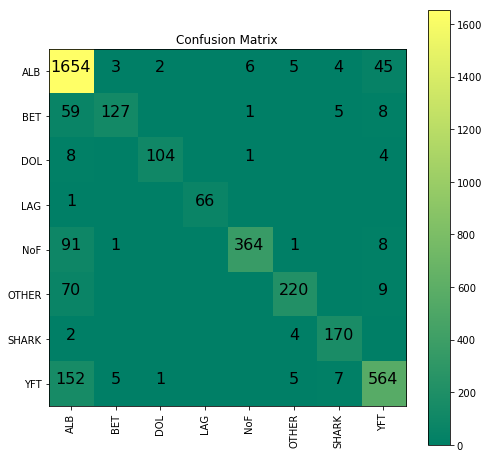

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt

print(classification_report(tt, pp,
                            target_names=classes))

conf_mat = confusion_matrix(tt, pp)

fig = plt.figure(figsize=(8,8))
width = conf_mat.shape[1]
height = conf_mat.shape[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c > 0:
            plt.text(j , i, c, horizontalalignment="center", fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(8), classes, rotation=90)
_ = plt.yticks(range(8), classes)

In [1]:
import pickle

In [60]:
with open("../intermediate/prediction.pkl", "wb") as f:
    pickle.dump((t, p), f, pickle.HIGHEST_PROTOCOL)

In [12]:
with open("../intermediate/prediction.pkl", "rb") as f:
    a =  pickle.load(f)

EOFError: Ran out of input